In [1]:
import torch
import math
from torch.nn import functional as F
from torch import nn
import matplotlib.pyplot as plt
import os   
from torch.nn.init import xavier_normal_, xavier_normal
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

In [2]:
def generate_disc_set(nb):
    # creating the circle in the middle of the points
    axis = torch.FloatTensor(1,2).uniform_(0.5,0.5)
    r = 1/((2*math.pi)**0.5)
    
    train_input   =  torch.FloatTensor(nb, 2).uniform_(0,1)
    train_target  =  torch.FloatTensor(nb, 2)
    train_mask    =  torch.FloatTensor(nb, 1)
    test_input    =  torch.FloatTensor(nb, 2).uniform_(0,1)
    test_target   =  torch.FloatTensor(nb, 2)
    test_mask     =  torch.FloatTensor(nb, 1)
    
    for i in range(0, len(train_input)):
        a = abs((train_input[i] - axis).pow(2).sum(1).view(-1).pow(0.5))
        b = abs((test_input[i]  - axis).pow(2).sum(1).view(-1).pow(0.5))
    
        if a < r:
            train_target[i][0] = 0
            train_target[i][1] = 1
            train_mask[i]      = 1
        else:
            train_target[i][0] = 1
            train_target[i][1] = 0
            train_mask[i]      = 0
            
        if b < r:
            test_target[i][0] = 0
            test_target[i][1] = 1
            test_mask[i]      = 1
        else:
            test_target[i][0] = 1
            test_target[i][1] = 0
            test_mask[i]      = 0
        
    return train_input, train_target, test_input, test_target, test_mask, train_mask

In [3]:
train_input, train_target, test_input, test_target, test_mask, train_mask = generate_disc_set(3000)

In [4]:
def plot_set(data_input, data_mask):

    train_scatter = torch.cat((train_input, train_mask),1)
    train_scatter_false = train_scatter[train_scatter[:,2] == 0]
    train_scatter_true = train_scatter[train_scatter[:,2] == 1]
    
    plt.figure(figsize=(5, 5))
    plt.scatter(train_scatter_false[:,0], train_scatter_false[:,1], )
    plt.scatter(train_scatter_true[:,0], train_scatter_true[:,1], )

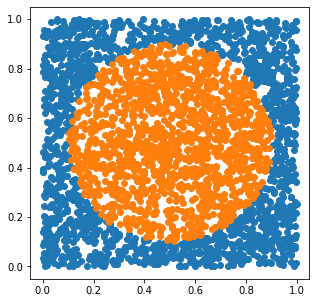

In [5]:
plot_set(train_input, train_mask)

In [6]:
def ReLu(x):
    return x.clamp(min=0)

def dReLu(x):
    return (torch.sign(x) + 1)/2

In [7]:
def loss(v, t):
    return (v - t).pow(2).sum()

def dloss(v, t):
    return 2 * (v - t)

In [8]:
def sigma(x):
    return x.tanh()

def dsigma(x):
    return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)

In [9]:
def forward_pass(w1, b1, w2, b2,w3, b3,  x):
    x0 = x
    s1 = w1.mv(x0) + b1
    x1 = ReLu(s1)
    s2 = w2.mv(x1) + b2
    x2 = ReLu(s2)
    s3 = w3.mv(x2) + b3
    x3 = ReLu(s3)

    return x0, s1, x1, s2, x2, s3, x3

In [18]:
def forward_pass(w1, b1, w2, b2,w3, b3,  x):
    x0 = x
    s1 = w1.mv(x0) + b1
    x1 = ReLu(s1)
    s2 = w2.mv(x1) + b2
    x2 = ReLu(s2)
    s3 = w3.mv(x2) + b3
    x3 = ReLu(s3)

    return x0, s1, x1, s2, x2, s3, x3

def backward_pass(w1, b1, w2, b2, w3, b3,
                  t,
                  x, s1, x1, s2, x2, s3, x3,
                  dl_dw1, dl_db1, dl_dw2, dl_db2,dl_dw3,dl_db3):
    x0 = x
    dl_dx3 = dloss(x3, t)
    dl_ds3 = dReLu(s3) * dl_dx3
    
    dl_dx2 = w3.t().mv(dl_ds3)
    dl_ds2 = dReLu(s2) * dl_dx2
    
    dl_dx1 = w2.t().mv(dl_ds2)
    dl_ds1 = dReLu(s1) * dl_dx1
    
    
    dl_dw3.add_(dl_ds3.view(-1, 1).mm(x2.view(1, -1)))
    dl_db3.add_(dl_ds3) 

    dl_dw2.add_(dl_ds2.view(-1, 1).mm(x1.view(1, -1)))
    dl_db2.add_(dl_ds2)
    
    dl_dw1.add_(dl_ds1.view(-1, 1).mm(x0.view(1, -1)))
    dl_db1.add_(dl_ds1)

######################################################################

nb_classes = train_target.size(1)
nb_train_samples = train_input.size(0)

zeta = 1

train_target = train_target * zeta
test_target = test_target * zeta

nb_hidden = 25
eta = 0.0001
epsilon = 1e-3

#SGD momentum
momentum = 0.9

#weights and biases
w1 = xavier_normal_(torch.empty(nb_hidden, train_input.size(1)).normal_(0, epsilon))
b1 = torch.empty(nb_hidden).normal_(0, epsilon)

w2 = xavier_normal_(torch.empty(nb_hidden, nb_hidden).normal_(0, epsilon))
b2 = torch.empty(nb_hidden).normal_(0, epsilon)

w3 = xavier_normal_(torch.empty(nb_classes, nb_hidden).normal_(0, epsilon))
b3 = torch.empty(nb_classes).normal_(0, epsilon)


#Gradient
dl_dw1 = torch.empty(w1.size())
dl_db1 = torch.empty(b1.size())

dl_dw2 = torch.empty(w2.size())
dl_db2 = torch.empty(b2.size())

dl_dw3 = torch.empty(w3.size())
dl_db3 = torch.empty(b3.size())


u_w1 = torch.zeros(w1.size())
u_b1 = torch.zeros(b1.size())
    
u_w2 = torch.zeros(w2.size())
u_b2 = torch.zeros(b2.size())
    
u_w3 = torch.zeros(w3.size())
u_b3 = torch.zeros(b3.size())



for k in range(2000):

    # Back-prop

    acc_loss = 0
    nb_train_errors = 0

    dl_dw1.zero_()
    dl_db1.zero_()
    
    dl_dw2.zero_()
    dl_db2.zero_()
    
    dl_dw3.zero_()
    dl_db3.zero_()

    for n in range(nb_train_samples):
        x0, s1, x1, s2, x2, s3, x3 = forward_pass(w1, b1, w2, b2, w3, b3, train_input[n])

        
        pred = x3.max(0)[1].item()
        target = 0
        if train_target[n][0] == 0 : target = 1
        if target != pred : nb_train_errors = nb_train_errors + 1
        acc_loss = acc_loss + loss(x3, train_target[n])
        

        backward_pass(w1, b1, w2, b2,w3,b3,
                      train_target[n],
                      x0, s1, x1, s2, x2,s3,x3,
                      dl_dw1, dl_db1, dl_dw2, dl_db2,dl_dw3,dl_db3)
    #ut = γut−1 + ηgt
    #wt+1 = wt − ut

    
    u_w1 = u_w1 * momentum + eta * dl_dw1
    u_b1 = u_b1 * momentum + eta * dl_db1
    
    u_w2 = u_w2 * momentum + eta * dl_dw2
    u_b2 = u_b2 * momentum + eta * dl_db2
    
    u_w3 = u_w3 * momentum + eta * dl_dw3
    u_b3 = u_b3 * momentum + eta * dl_db3
    
    
    w1 = w1 - u_w1
    b1 = b1 - u_b1
    
    w2 = w2 - u_w2
    b2 = b2 - u_b2
    
    w3 = w3 - u_w3
    b3 = b3 - u_b3
    
    ## Normal gradient step
    #if momentum != 1:
        #momentum = momentum + 0.01
        
    #eta = eta * momentum
    #print(eta)
    
    
    

    # Test error

    nb_test_errors = 0

    for n in range(test_input.size(0)):
        _, _, _, _,_,_, x3 = forward_pass(w1, b1, w2, b2,w3,b3, test_input[n])

        pred = x3.max(0)[1].item()
        target = 0
        if test_target[n][0] == 0 : target = 1
        if target != pred : nb_test_errors = nb_test_errors + 1

    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(k,
                  acc_loss,
                  (100 * nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))

0 acc_train_loss 2482.60 acc_train_error 51.93% test_error 48.13%
1 acc_train_loss 2663.84 acc_train_error 51.93% test_error 48.13%
2 acc_train_loss 2383.87 acc_train_error 51.93% test_error 48.13%
3 acc_train_loss 2423.04 acc_train_error 51.93% test_error 48.13%
4 acc_train_loss 2315.50 acc_train_error 51.93% test_error 48.13%
5 acc_train_loss 2378.80 acc_train_error 51.93% test_error 48.13%
6 acc_train_loss 2261.65 acc_train_error 51.93% test_error 48.13%
7 acc_train_loss 2307.36 acc_train_error 51.93% test_error 40.43%
8 acc_train_loss 1579.22 acc_train_error 40.07% test_error 51.87%
9 acc_train_loss 1716.27 acc_train_error 48.07% test_error 43.57%
10 acc_train_loss 1704.58 acc_train_error 40.70% test_error 43.87%
11 acc_train_loss 1435.67 acc_train_error 47.40% test_error 29.97%
12 acc_train_loss 1499.94 acc_train_error 30.83% test_error 44.73%
13 acc_train_loss 1467.70 acc_train_error 40.13% test_error 46.53%
14 acc_train_loss 1325.36 acc_train_error 41.53% test_error 28.53%
15 ac

KeyboardInterrupt: 

In [22]:
w1.zero_()

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [54]:

weight_1, bias_1, weight_2, bias_2, weight_3, bias_3 = torch.clone(w1),torch.clone(b1),torch.clone(w2),torch.clone(b2),torch.clone(w3),torch.clone(b3)




In [55]:
def previsao(w1, b1, w2, b2,w3, b3,  x):
    x0 = x
    s1 = w1.mv(x0) + b1
    x1 = ReLu(s1)
    s2 = w2.mv(x1) + b2
    x2 = ReLu(s2)
    s3 = w3.mv(x2) + b3
    x3 = ReLu(s3)

    return x3

In [73]:
train_input, train_target, test_input, test_target, test_mask, train_mask = generate_disc_set(10000)

In [74]:
    pred_target =  torch.FloatTensor(test_input.size(0), 1)
    
    nb_test_errors = 0
    for n in range(test_input.size(0)):
        pred = previsao(weight_1, bias_1, weight_2, bias_2, weight_3, bias_3, test_input[n])

        pred = pred.max(0)[1].item()
        target = 0
        if test_target[n][0] == 0 : target = 1
        if target != pred : nb_test_errors = nb_test_errors + 1
        pred_target[n] = target

    print('test_error {:.02f}%'.format((100 * nb_test_errors) / test_input.size(0)))

test_error 1.20%


In [75]:
test_scatter = torch.cat((test_input, pred_target),1)
test_scatter_false = test_scatter[test_scatter[:,2] == 0]
test_scatter_true  = test_scatter[test_scatter[:,2] == 1]

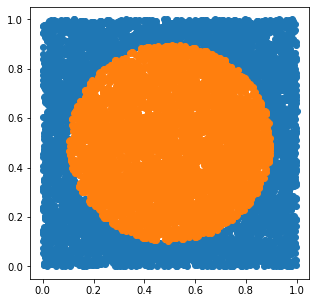

In [76]:
# best result so far with the classeles 2000 epochs 0.9 momentum and  eta 0.0001

plt.figure(figsize=(5, 5))
plt.scatter(test_scatter_false[:,0], test_scatter_false[:,1], )
plt.scatter(test_scatter_true[:,0], test_scatter_true[:,1], )

In [80]:
a_1 = a_1 * momentum + eta * dl_dw1

NameError: name 'a_1' is not defined